In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import numpy as np
import seaborn as sns
import pandas as pd

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

gan_variants = ["vanilla", "DCGAN", "WGAN"]
balanced_paths = [f"../balanced_dataset_{g}_fashion_mnist/" for g in gan_variants]
imbalanced_paths = [f"../imbalanced_dataset_{g}_fashion_mnist/" for g in gan_variants]

all_metrics_bal = {}
all_metrics_imbal = {}

In [34]:
def create_model(num_classes=10):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

In [35]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def load_and_split_data(data_path, labels_path, batch_size=32, seed=42):
    data = torch.load(data_path)
    labels = torch.load(labels_path)

    if data.max() > 1:
        data = data.float() / 255.0
    if data.ndim == 3:
        data = data.unsqueeze(1)
    data = data.repeat(1, 3, 1, 1)  # [N, 3, 28, 28]

    indices = np.arange(len(data))
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        indices, labels, test_size=0.4, stratify=labels, random_state=seed
    )
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.5, stratify=y_temp, random_state=seed
    )

    train_dataset = TensorDataset(data[train_idx], labels[train_idx])
    val_dataset = TensorDataset(data[val_idx], labels[val_idx])
    test_dataset = TensorDataset(data[test_idx], labels[test_idx])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [36]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    model.train()
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        running_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses

In [37]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = torch.argmax(out, dim=1)

            y_true.extend(y.numpy())
            y_pred.extend(preds.cpu().numpy())

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "f1": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "conf_matrix": confusion_matrix(y_true, y_pred)
    }
    return metrics


In [38]:
def plot_losses(train_losses, val_losses, title="Loss Curve"):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [39]:
def plot_metrics(metrics_bal, metrics_imbal):
    keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    bal_vals = [metrics_bal[k] for k in keys]
    imbal_vals = [metrics_imbal[k] for k in keys]

    x = np.arange(len(keys))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, bal_vals, width, label='Balanced')
    plt.bar(x + width/2, imbal_vals, width, label='Imbalanced')
    plt.xticks(x, [k.capitalize() for k in keys])
    plt.ylabel("Score")
    plt.title("Test Metric Comparison: Balanced vs Imbalanced")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [40]:
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()



=== Processing vanilla ===

--- Balanced Dataset ---
Epoch 1/10, Train Loss: 1.5154, Val Loss: 1.1292
Epoch 2/10, Train Loss: 1.0674, Val Loss: 0.9549
Epoch 3/10, Train Loss: 0.9699, Val Loss: 0.8914
Epoch 4/10, Train Loss: 0.9229, Val Loss: 0.8457
Epoch 5/10, Train Loss: 0.8877, Val Loss: 0.8280
Epoch 6/10, Train Loss: 0.8694, Val Loss: 0.8189
Epoch 7/10, Train Loss: 0.8471, Val Loss: 0.7809
Epoch 8/10, Train Loss: 0.8419, Val Loss: 0.7822
Epoch 9/10, Train Loss: 0.8335, Val Loss: 0.7730
Epoch 10/10, Train Loss: 0.8292, Val Loss: 0.7717


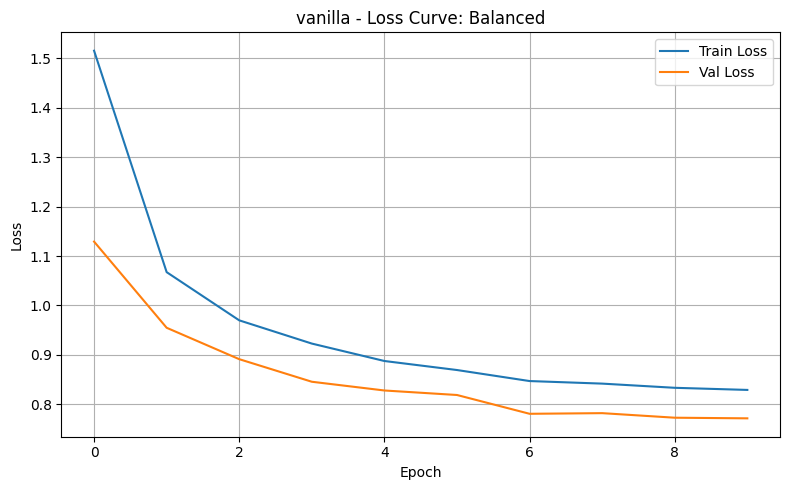


--- Imbalanced Dataset ---
Epoch 1/10, Train Loss: 1.6340, Val Loss: 1.2264
Epoch 2/10, Train Loss: 1.1757, Val Loss: 1.0442
Epoch 3/10, Train Loss: 1.0630, Val Loss: 0.9713
Epoch 4/10, Train Loss: 1.0080, Val Loss: 0.9287
Epoch 5/10, Train Loss: 0.9768, Val Loss: 0.8936
Epoch 6/10, Train Loss: 0.9523, Val Loss: 0.8876
Epoch 7/10, Train Loss: 0.9407, Val Loss: 0.8695
Epoch 8/10, Train Loss: 0.9306, Val Loss: 0.8520
Epoch 9/10, Train Loss: 0.9166, Val Loss: 0.8394
Epoch 10/10, Train Loss: 0.9035, Val Loss: 0.8359


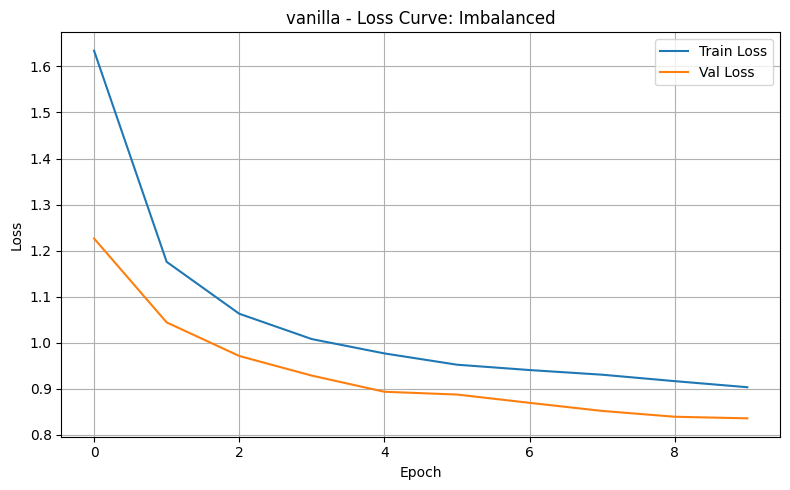


=== Processing DCGAN ===

--- Balanced Dataset ---
Epoch 1/10, Train Loss: 1.5494, Val Loss: 1.0992
Epoch 2/10, Train Loss: 1.0666, Val Loss: 0.9562
Epoch 3/10, Train Loss: 0.9604, Val Loss: 0.8725
Epoch 4/10, Train Loss: 0.9120, Val Loss: 0.8511
Epoch 5/10, Train Loss: 0.8880, Val Loss: 0.8229
Epoch 6/10, Train Loss: 0.8680, Val Loss: 0.8257
Epoch 7/10, Train Loss: 0.8514, Val Loss: 0.8071
Epoch 8/10, Train Loss: 0.8387, Val Loss: 0.7934
Epoch 9/10, Train Loss: 0.8338, Val Loss: 0.7764
Epoch 10/10, Train Loss: 0.8257, Val Loss: 0.7842


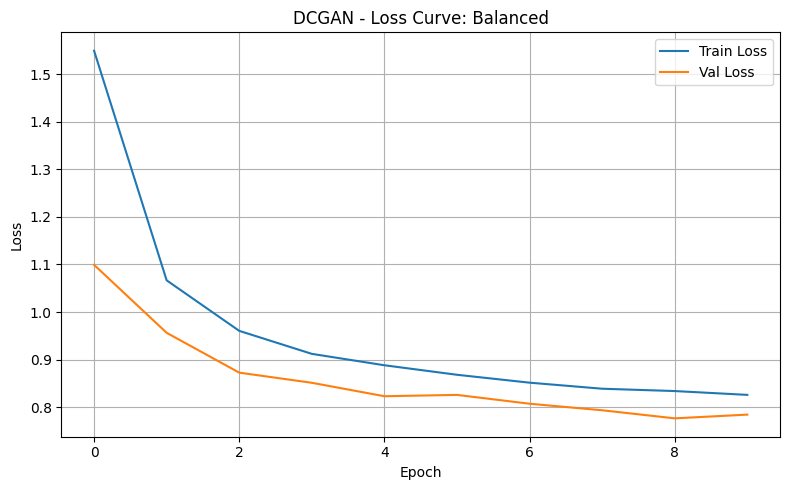


--- Imbalanced Dataset ---
Epoch 1/10, Train Loss: 1.6185, Val Loss: 1.2134
Epoch 2/10, Train Loss: 1.1752, Val Loss: 1.0589
Epoch 3/10, Train Loss: 1.0714, Val Loss: 0.9834
Epoch 4/10, Train Loss: 1.0149, Val Loss: 0.9488
Epoch 5/10, Train Loss: 0.9756, Val Loss: 0.9133
Epoch 6/10, Train Loss: 0.9542, Val Loss: 0.9003
Epoch 7/10, Train Loss: 0.9363, Val Loss: 0.8819
Epoch 8/10, Train Loss: 0.9308, Val Loss: 0.8600
Epoch 9/10, Train Loss: 0.9151, Val Loss: 0.8597
Epoch 10/10, Train Loss: 0.9059, Val Loss: 0.8540


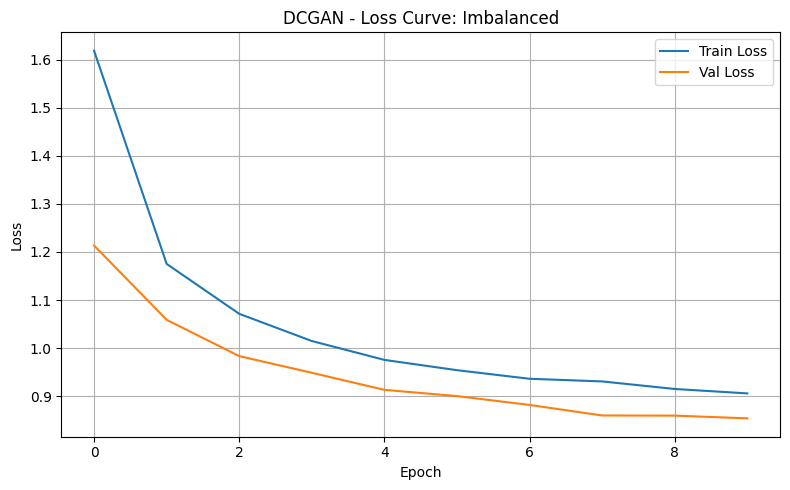


=== Processing WGAN ===

--- Balanced Dataset ---
Epoch 1/10, Train Loss: 1.5239, Val Loss: 1.1199
Epoch 2/10, Train Loss: 1.0703, Val Loss: 0.9445
Epoch 3/10, Train Loss: 0.9663, Val Loss: 0.8690
Epoch 4/10, Train Loss: 0.9253, Val Loss: 0.8503
Epoch 5/10, Train Loss: 0.8898, Val Loss: 0.8196
Epoch 6/10, Train Loss: 0.8728, Val Loss: 0.7986
Epoch 7/10, Train Loss: 0.8555, Val Loss: 0.7802
Epoch 8/10, Train Loss: 0.8441, Val Loss: 0.7842
Epoch 9/10, Train Loss: 0.8350, Val Loss: 0.7665
Epoch 10/10, Train Loss: 0.8236, Val Loss: 0.7649


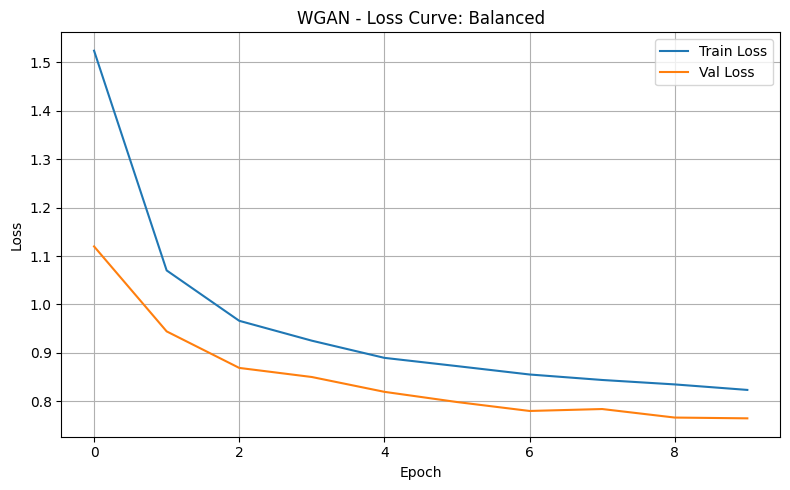


--- Imbalanced Dataset ---
Epoch 1/10, Train Loss: 1.6376, Val Loss: 1.2357
Epoch 2/10, Train Loss: 1.1790, Val Loss: 1.0650
Epoch 3/10, Train Loss: 1.0722, Val Loss: 0.9900
Epoch 4/10, Train Loss: 1.0176, Val Loss: 0.9582
Epoch 5/10, Train Loss: 0.9845, Val Loss: 0.9225
Epoch 6/10, Train Loss: 0.9585, Val Loss: 0.9022
Epoch 7/10, Train Loss: 0.9354, Val Loss: 0.8774
Epoch 8/10, Train Loss: 0.9251, Val Loss: 0.8754
Epoch 9/10, Train Loss: 0.9164, Val Loss: 0.8668
Epoch 10/10, Train Loss: 0.9052, Val Loss: 0.8581


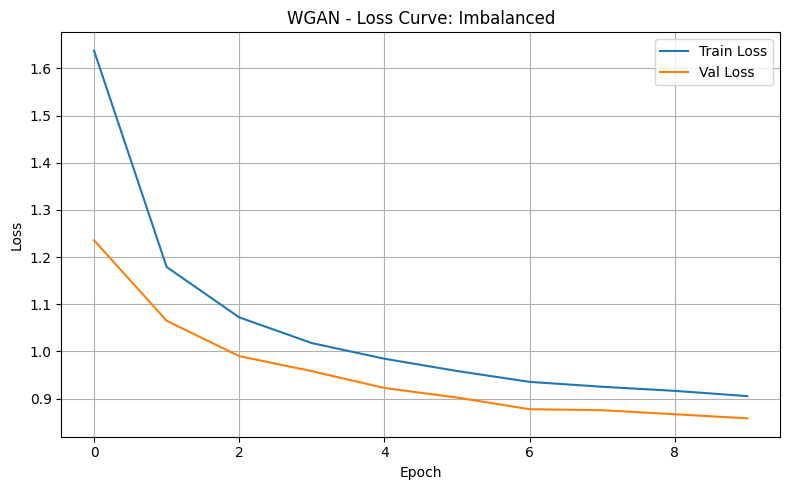

In [41]:
for variant, bal_path, imbal_path in zip(gan_variants, balanced_paths, imbalanced_paths):
    print(f"\n=== Processing {variant} ===")

    # === Balanced dataset ===
    print("\n--- Balanced Dataset ---")
    train_bal, val_bal, test_bal = load_and_split_data(f"{bal_path}data.pt", f"{bal_path}labels.pt")
    model_bal = create_model(num_classes=10)
    model_bal, train_loss_bal, val_loss_bal = train(model_bal, train_bal, val_bal, epochs)
    metrics_bal = evaluate(model_bal, test_bal)
    plot_losses(train_loss_bal, val_loss_bal, title=f"{variant} - Loss Curve: Balanced")
    all_metrics_bal[variant] = metrics_bal

    # === Imbalanced dataset ===
    print("\n--- Imbalanced Dataset ---")
    train_imbal, val_imbal, test_imbal = load_and_split_data(f"{imbal_path}data.pt", f"{imbal_path}labels.pt")
    model_imbal = create_model(num_classes=10)
    model_imbal, train_loss_imbal, val_loss_imbal = train(model_imbal, train_imbal, val_imbal, epochs)
    metrics_imbal = evaluate(model_imbal, test_imbal)
    plot_losses(train_loss_imbal, val_loss_imbal, title=f"{variant} - Loss Curve: Imbalanced")
    all_metrics_imbal[variant] = metrics_imbal

## Kinda Redundant

In [42]:
# def plot_all_metrics_separately(metrics_bal_dict, metrics_imbal_dict):
#     keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']

#     for metric in keys:
#         plt.figure(figsize=(8, 5))
#         values_bal = [metrics_bal_dict[variant][metric] for variant in metrics_bal_dict]
#         values_imbal = [metrics_imbal_dict[variant][metric] for variant in metrics_imbal_dict]

#         x = np.arange(len(metrics_bal_dict))
#         width = 0.35

#         plt.bar(x - width / 2, values_bal, width, label='Balanced', color='skyblue')
#         plt.bar(x + width / 2, values_imbal, width, label='Imbalanced', color='salmon')

#         plt.xticks(x, list(metrics_bal_dict.keys()))
#         plt.ylabel(metric.capitalize())
#         plt.title(f"{metric.capitalize()} Comparison Across GAN Variants")
#         plt.ylim(0, 1)
#         plt.legend(loc='lower left', bbox_to_anchor=(0, -0.25), ncol=1)
#         plt.grid(axis='y', linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()

# plot_all_metrics_separately(all_metrics_bal, all_metrics_imbal)

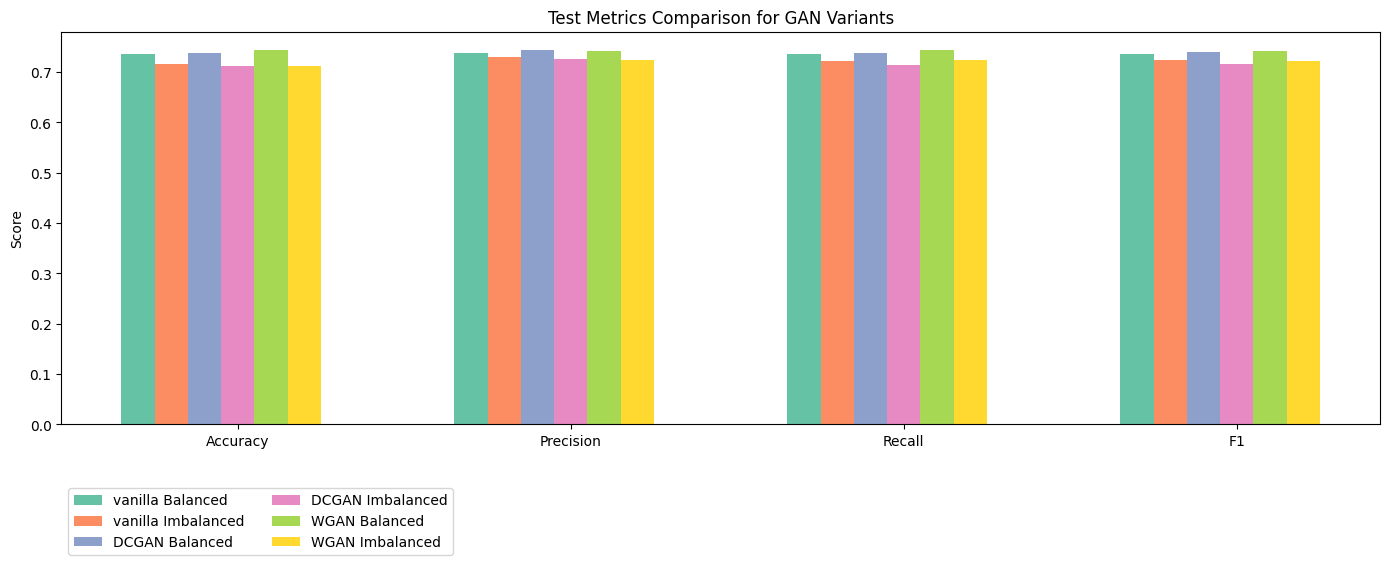

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_metrics(metrics_bal_dict, metrics_imbal_dict):
    keys = ['accuracy', 'precision', 'recall', 'f1']
    x = np.arange(len(keys))
    width = 0.2
    color_cycle = plt.cm.Set2.colors
    plt.figure(figsize=(14, 6))

    for i, variant in enumerate(metrics_bal_dict.keys()):
        bal_vals = [metrics_bal_dict[variant][k] for k in keys]
        imbal_vals = [metrics_imbal_dict[variant][k] for k in keys]
        offset = (i - len(metrics_bal_dict) / 2) * width

        bal_color = color_cycle[(2 * i) % len(color_cycle)]
        imbal_color = color_cycle[(2 * i + 1) % len(color_cycle)]

        plt.bar(x + offset, bal_vals, width / 2, label=f'{variant} Balanced', color=bal_color)
        plt.bar(x + offset + width / 2, imbal_vals, width / 2, label=f'{variant} Imbalanced', color=imbal_color)

    plt.xticks(x, [k.capitalize() for k in keys])
    plt.ylabel("Score")
    plt.title("Test Metrics Comparison for GAN Variants")
    plt.legend(loc='lower left', bbox_to_anchor=(0, -0.35), ncol=2)
    plt.tight_layout()
    plt.show()

plot_all_metrics(all_metrics_bal, all_metrics_imbal)


In [44]:
def display_metrics_comparison(all_metrics_bal, all_metrics_imbal):
    keys = ['accuracy', 'precision', 'recall', 'f1']

    for variant in all_metrics_bal.keys():
        print(f"\n=== {variant} ===")
        data = {
            "Imbalanced": [all_metrics_imbal[variant][k] for k in keys],
            "Balanced": [all_metrics_bal[variant][k] for k in keys],
        }

        data["Absolute Diff"] = [
            all_metrics_bal[variant][k] - all_metrics_imbal[variant][k] for k in keys
        ]
        data["% Improvement"] = [
            ((all_metrics_bal[variant][k] - all_metrics_imbal[variant][k]) / all_metrics_imbal[variant][k]) * 100
            if all_metrics_imbal[variant][k] != 0 else 0
            for k in keys
        ]

        df = pd.DataFrame(data, index=[k.capitalize() for k in keys])
        df["% Improvement"] = df["% Improvement"].map("{:+.2f}%".format)
        df["Absolute Diff"] = df["Absolute Diff"].map("{:+.4f}".format)
        df["Imbalanced"] = df["Imbalanced"].map("{:.4f}".format)
        df["Balanced"] = df["Balanced"].map("{:.4f}".format)

        display(df)
        
display_metrics_comparison(all_metrics_bal, all_metrics_imbal)


=== vanilla ===


,Imbalanced,Balanced,Absolute Diff,% Improvement
Accuracy,0.7150,0.7362,+0.0212,+2.97%
Precision,0.7291,0.7370,+0.0079,+1.08%
Recall,0.7212,0.7363,+0.0151,+2.09%
F1,0.7239,0.7349,+0.0111,+1.53%



=== DCGAN ===


,Imbalanced,Balanced,Absolute Diff,% Improvement
Accuracy,0.7109,0.7380,+0.0271,+3.82%
Precision,0.7251,0.7428,+0.0177,+2.45%
Recall,0.7144,0.7376,+0.0232,+3.25%
F1,0.7153,0.7394,+0.0241,+3.37%



=== WGAN ===


,Imbalanced,Balanced,Absolute Diff,% Improvement
Accuracy,0.7115,0.7432,+0.0316,+4.45%
Precision,0.7229,0.7426,+0.0197,+2.72%
Recall,0.7232,0.7430,+0.0198,+2.73%
F1,0.7225,0.7421,+0.0196,+2.72%


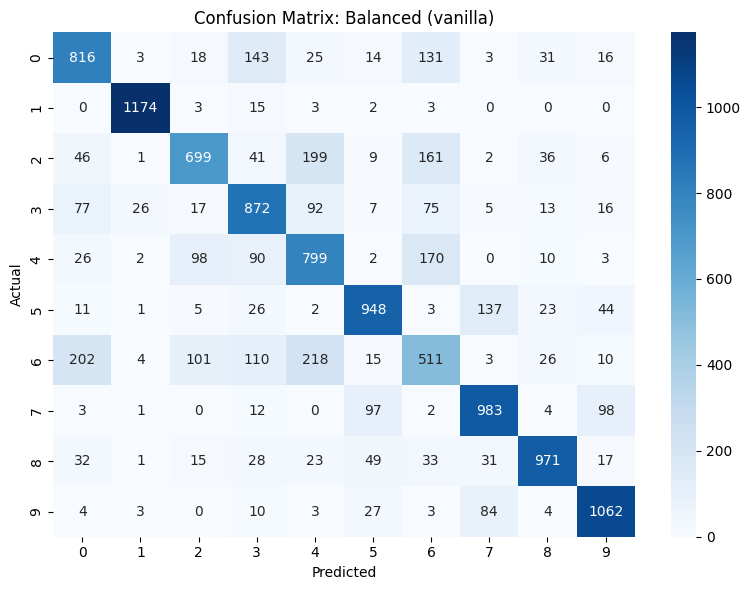

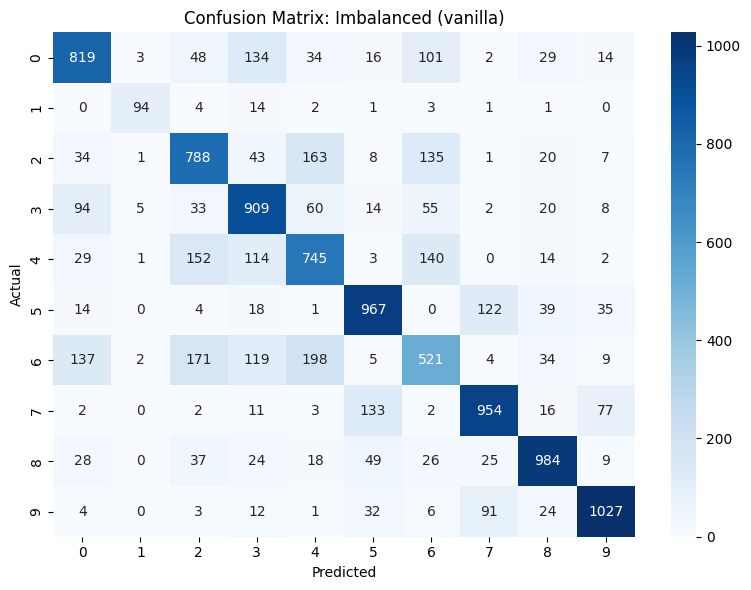

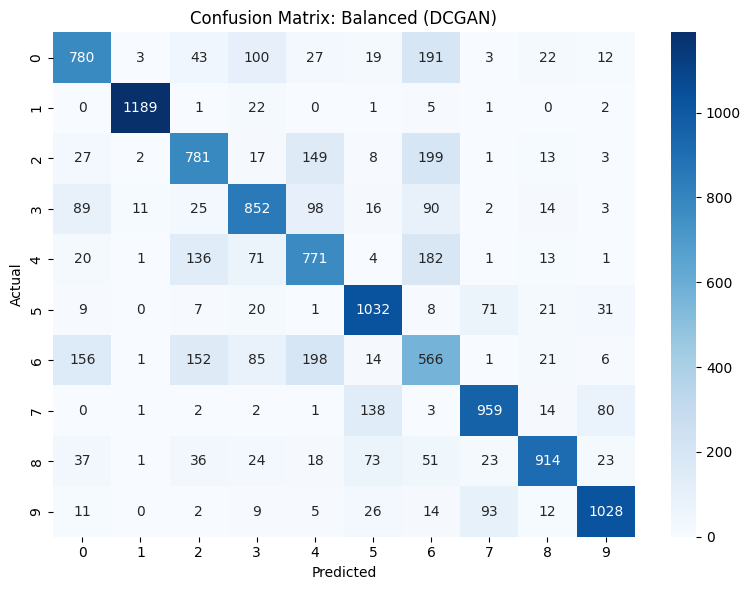

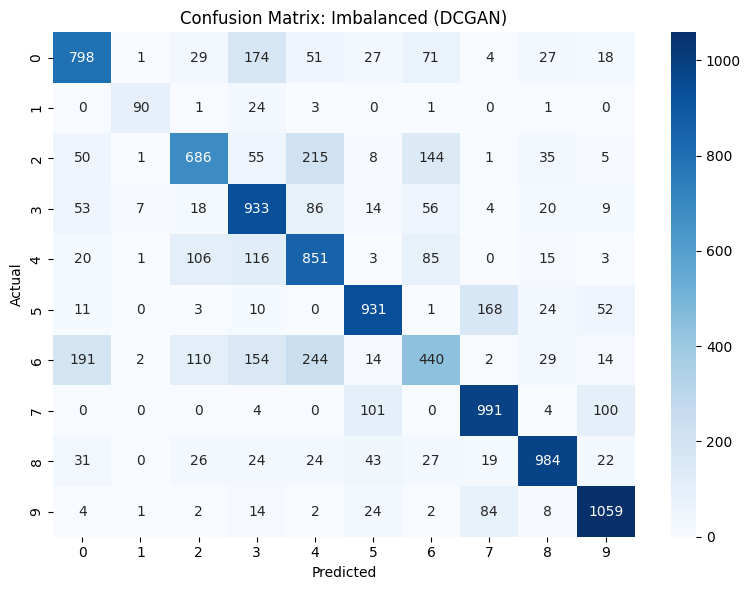

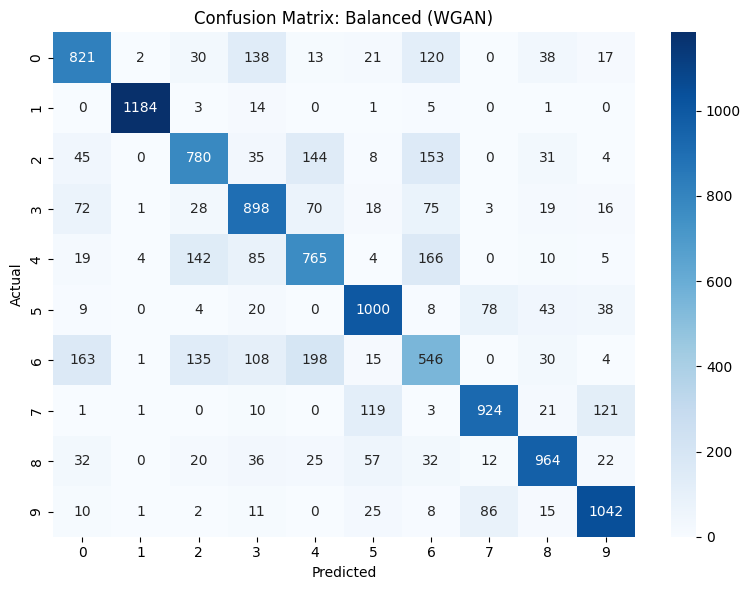

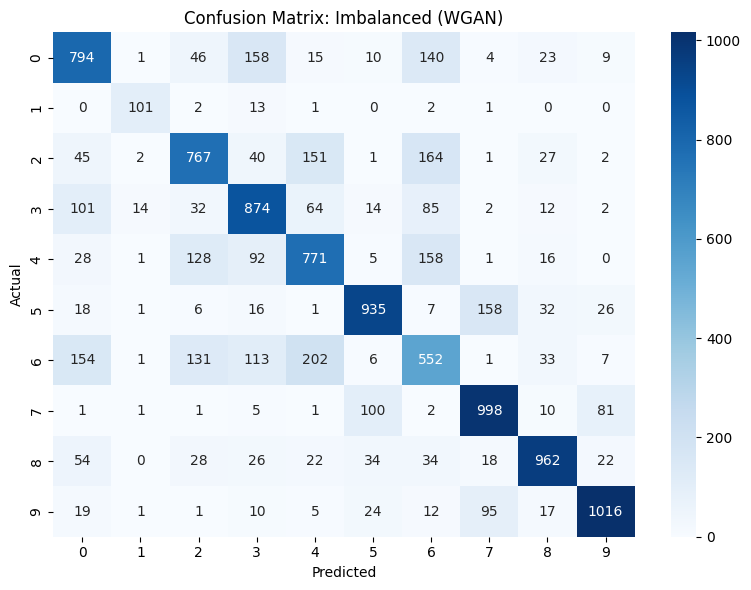

In [45]:
for variant in gan_variants:
    plot_conf_matrix(all_metrics_bal[variant]['conf_matrix'], f"Confusion Matrix: Balanced ({variant})")
    plot_conf_matrix(all_metrics_imbal[variant]['conf_matrix'], f"Confusion Matrix: Imbalanced ({variant})")